# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta

is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on CoLab
Mounted at /content/drive


In [3]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone'
Hypers.Config.data_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/data'
Hypers.Config.model_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/model'
Hypers.Config.log_path='/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/log'


In [6]:
suffix = "All_omni_8"

In [7]:
# Optional: Split data into train and test
# You have to run this cell if you changed your feature,rating dataset
merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}.pkl"))
train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)
print(len(train_dict), len(test_dict))

675 168


# LSTM

In [ ]:
import LSTMDataset
importlib.reload(LSTMDataset)
import LSTMModel
importlib.reload(LSTMModel)

model_type = "Lstm"

In [ ]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "train_dict.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, "test_dict.pkl"))
print(f"{len(train_dict)}", f"{len(test_dict)}")

# max_seq_len = max(max([len(entries) for entries in train_dict.values()]), max([len(entries) for entries in test_dict.values()]))
max_seq_len = 2
print(f"{max_seq_len=}")

model = LSTMModel.LSTMModel(input_size=len(Hypers.feature_list),
                                      hidden_size=Hypers.Config.hidden_size,
                                      num_layers=max_seq_len,
                                      proj_size=Hypers.Config.proj_size,
                                      model_type=model_type)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set, test_set = LSTMDataset.LSTMDataset(train_dict), LSTMDataset.LSTMDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.RatingSet.custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=LSTMDataset.RatingSet.custom_collate_fn)

trainer = Trainer.Trainer(model, criterion, optimizer, device, train_loader, test_loader, max_seq_len)
train_loss, train_accuracy, test_loss, test_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, test_loss, test_accuracy, identifier=f"{model_type}_{suffix}")

In [ ]:
utils.plot_graph(trainer.train_loss_history, trainer.train_acccuracy_history, trainer.test_loss_history, trainer.test_acccuracy_history)

# Regression

In [8]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

model_type = "Regr"

In [9]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")

len(train_dict)=675 len(test_dict)=168


In [19]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0])
print(f"{input_size=}")

input_size=776


Vaild Epoch 199: 100%|██████████| 200/200 [40:07<00:00, 12.04s/it, Loss: 0.011]


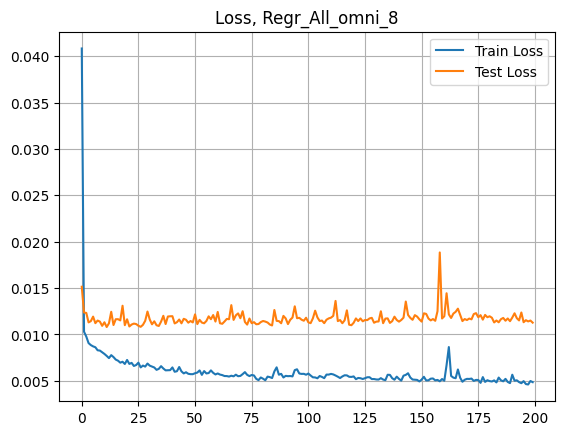

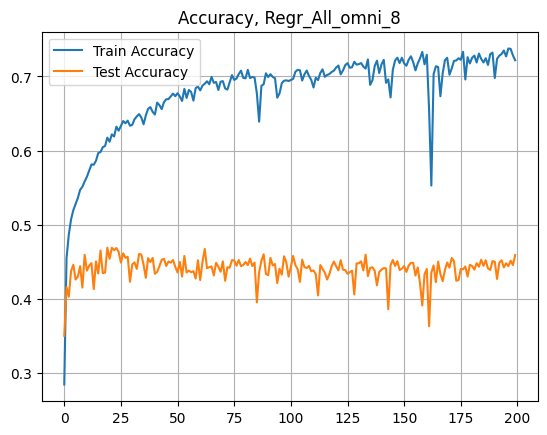

In [20]:
train_set = RegressionDataset.RegressionDataset(train_dict)
valid_set = RegressionDataset.RegressionDataset(test_dict)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)

model = RegressionModel.RegressionModel(input_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Conv1d

In [21]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

In [22]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=675 len(test_dict)=168
All_omni_8


In [24]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // 8
print(f"{input_size=}")

input_size=97


In [ ]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=8)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=8)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=97)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

Vaild Epoch 62:  31%|███       | 62/200 [14:48<32:19, 14.06s/it, Loss: 0.012]

# Infer

In [ ]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from '/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone/Inferencer.py'>

In [ ]:
test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [ ]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([3., 3., 3., 4., 4., 4., 3., 3., 3., 3.], device='cuda:0')
tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], device='cuda:0')


In [ ]:
print(diff_counter)

Counter({1.0: 3117, 0.0: 2911, 2.0: 486, 3.0: 67, 6.0: 57, 4.0: 37, 5.0: 31, 8.0: 3, 7.0: 2, 9.0: 1})


In [ ]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=6712


In [ ]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.43370083432657924,
 0.898092967818832,
 0.9705005959475567,
 0.9804827175208581,
 0.9859952324195471]

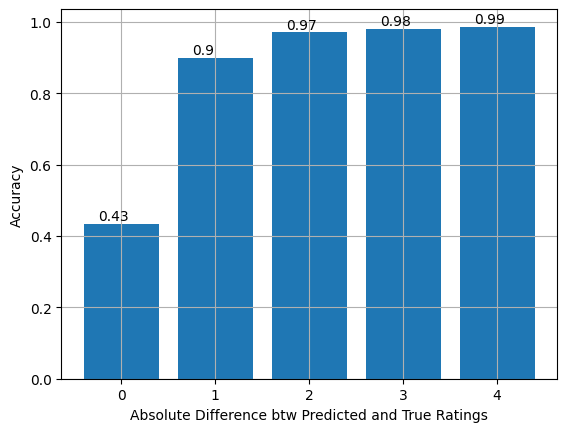

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()